Aim: Convolution of an input image with **three** standard filters and **one** custom filter

Assumptions:
    0. Only one Input Image can be taken at a time
    1. Input Image can be either RGB or GrayScale, though for computation it is converted to GrayScale
    2. Standard GrayScale conversion is followed (i.e. {R*0.299 + G*0.587 + B*0.114})
    3. There are no restrictions on size of Input Image
    4. Input Image width is reduced to 300px if width is greater than 300px
    4. While shrinking the size, aspect-ratio of Input Image is preserved
    5. Custom Filter has to be 2-Dimensional Array
    6. Result is visualised in form of GrayScale images
    7. Other parameters are implicit (eg: stride, padding, mean, sigma, ksize, etc.)

# Library Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.misc import imresize
%matplotlib inline

In [3]:
sess = tf.InteractiveSession()

# Utility Functions

In [4]:
def rgb2gray(rgb):
    color_channel = 1
    try:
        color_channel = rgb.shape[2]
    except:
        pass
    
    if color_channel == 1:
        print("Image is already GRAY scale")
        return rgb
    else:
        print ("Image successfully converted from RGB to GRAY scale")
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [5]:
def resize(img, max_width=300):
    old_height = img.shape[0]
    old_width = img.shape[1]
    
    if old_width > max_width:
        new_height = np.int(max_width * old_height / old_width)
        new_width = max_width

    return imresize(img, (new_height, new_width))

# Tensorflow code for **CONVOLUTION**

In [6]:
# Input image placeholder (i.e. image to be convolved)
img = tf.placeholder(tf.float32, shape=[None, None], name='img')
img_3d = tf.expand_dims(img, axis=2)
#print (img_3d.get_shape().as_list())
img_4d = tf.expand_dims(img_3d, axis=0)
#print(img_4d.get_shape().as_list())

# Other placeholders
mean = tf.placeholder(tf.float32, name='mean')
sigma = tf.placeholder(tf.float32, name='sigma')
ksize = tf.placeholder(tf.int32, name='ksize')

# Placeholder for the custom filter
# It should be 2-Dimensional
custom_filter = tf.placeholder(tf.float32, shape=[None, None], name='custom_filter')

# Constructing the standard filters
x = tf.linspace(-3.0, 3.0, ksize)
z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                   (2.0 * tf.pow(sigma, 2.0)))) *
      (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))
z_2d = tf.matmul(
  tf.reshape(z, tf.stack([ksize, 1])),
  tf.reshape(z, tf.stack([1, ksize])))
ys = - tf.sin(x)
ys = tf.reshape(ys, tf.stack([ksize, 1]))
ones = tf.ones(tf.stack([1, ksize]))
wave = tf.transpose(tf.matmul(ys, ones))
gabor = tf.multiply(wave, z_2d)

# Standard Filters in 4-D
wave_4d = tf.reshape(wave, [ksize, ksize, 1, 1])
z_4d = tf.reshape(z_2d, [ksize, ksize, 1, 1])
gabor_4d = tf.reshape(gabor, tf.stack([ksize, ksize, 1, 1]))
#** Custom Filter in 4-D**
custom_filter_3d = tf.expand_dims(custom_filter, axis=2)
custom_filter_4d = tf.expand_dims(custom_filter_3d, axis=3)

# Concatinating the Std filters
w_filters = tf.concat([wave_4d, z_4d, gabor_4d], axis=3)

# Performing the 'Convolution' operation
convolved = tf.nn.conv2d(img_4d, w_filters, strides=[1, 1, 1, 1], padding='SAME', name='convolved')
custom_convolved = tf.nn.conv2d(img_4d, custom_filter_4d, strides=[1, 1, 1, 1], padding='SAME', name='custom_convolved')

# Extracting the result i.e. set of 'convolved' images
convolved_img = (tf.concat([convolved, custom_convolved], axis=3))[0, :, :, :]

# Providing Inputs by User

In [7]:
# Select an Image (either grayscale or colored) of your choice
# Provide a suitable path to the Image file below
fileName = "4252185-black-and-white-image.jpg"                                                                       # <<---- Providing the input image

# If the Image is RGB, we convert it to GrayScale
input_img = rgb2gray(plt.imread(fileName))

# Shrink the Image if it's larger
input_img = resize(input_img)

# Create a CUSTOM_FILTER of 2-Dimensions
custom_ = np.array([[-1, -2, -3, 3, 2]]).astype(np.float32)                               # <<---- Providing the custom filter

# Creating 'feed-dictionary'
# Parameters (mean, sigma, ksize) can be tuned to change effect of standard filters
my_dict = {
    img: input_img,
    mean: 0.0,
    sigma: 0.5,
    ksize: 20,
    custom_filter: custom_
}

# Evaluating the result
resimage = convolved_img.eval(feed_dict=my_dict)
resfilter = (w_filters.eval(feed_dict=my_dict))[:,:,0,:]

Image successfully converted from RGB to GRAY scale


# Visualising the FILTERs and their CONVOLUTIONs

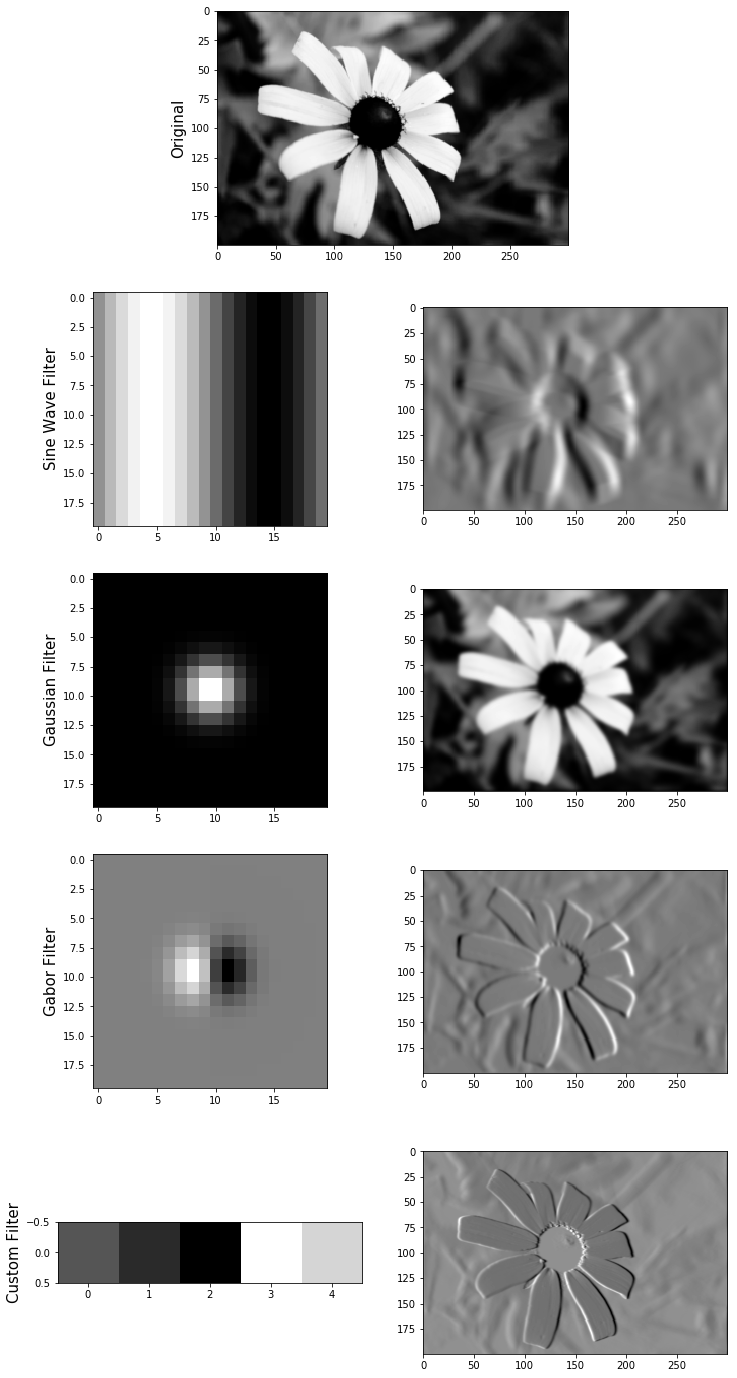

In [8]:
# Plotting the FILTERs and their corresponding CONVOLUTION Images
fig = plt.figure(figsize=(12,25))
gs = gridspec.GridSpec(5, 2)


## Original Image
ax12 = fig.add_subplot(gs[0,:])
ax12.imshow(input_img, cmap='gray')
ax12.set_ylabel('Original', fontsize=15)

## Wave Filter
ax21 = fig.add_subplot(gs[1,0])
ax21.imshow(resfilter[:,:,0], cmap='gray')
ax21.set_ylabel('Sine Wave Filter', fontsize=15)

ax22 = fig.add_subplot(gs[1,1])
ax22.imshow(resimage[:,:,0], cmap='gray')


## Gaussian Filter
ax31 = fig.add_subplot(gs[2,0])
ax31.imshow(resfilter[:,:,1], cmap='gray')
ax31.set_ylabel('Gaussian Filter', fontsize=15)

ax32 = fig.add_subplot(gs[2,1])
ax32.imshow(resimage[:,:,1], cmap='gray')


## Gabor Filter
ax41 = fig.add_subplot(gs[3,0])
ax41.imshow(resfilter[:,:,2], cmap='gray')
ax41.set_ylabel('Gabor Filter', fontsize=15)

ax42 = fig.add_subplot(gs[3,1])
ax42.imshow(resimage[:,:,2], cmap='gray')


## Custom filter
ax51 = fig.add_subplot(gs[4,0])
ax51.imshow(custom_, cmap='gray')
ax51.set_ylabel('Custom Filter', fontsize=15)

ax52 = fig.add_subplot(gs[4,1])
ax52.imshow(resimage[:,:,3], cmap='gray')

References :
    1. CADL course on Kadenze (https://github.com/pkmital/CADL/blob/master/session-1/lecture-1.ipynb)
    2. Visualisation of Basic Kernels (http://setosa.io/ev/image-kernels/)